In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import os
import warnings

from matplotlib.pyplot import scatter
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import RDKFingerprint
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from seaborn import scatterplot
from sklearn.covariance import ledoit_wolf

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR


### import the smiles_tg.csv file into a dataframe and identify how many unique smiles strings are in the dataset

In [108]:
df = pd.read_csv('smiles_tg.csv')
df.head()

,SMILES,tg
0,*C1COC2C1OCC2Oc1ccc(cc1)CNC(=O)CCCCCCC(=O)NCc1...,21.581731
1,*OC(CCC(OC(=O)Nc1ccc(cc1)Cc1ccc(cc1)NC(=O)*)C)C,63.589338
2,*OC(=O)c1ccc(cc1)C(=O)OCCCC(=O)NCc1ccc(cc1)CNC...,53.557261
3,*OC(=O)NCCNC(=O)OCC*,5.896093
4,*SCCCCC*,-55.378610


In [109]:
unique_smiles = df.SMILES.unique()
print("Total SMILES:",len(df))
print("Unique SMILES:",len(unique_smiles))

Total SMILES: 966
Unique SMILES: 964


WE hhave 2 duplicates that we need to drop

### drop the duplicate smiles strings in the dataset, keep the first entry and reset the index

In [110]:
df.drop_duplicates(subset=['SMILES'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("After dropping duplicates:", len(df))


After dropping duplicates: 964


### we are going to use the RDKit library to convert the smiles strings into molecular objects
### that we will use as features for our models
### lets first generate basic descriptors for the molecules

### here you will write a basic function called get_basic_descriptors, that takes a smiles string as input, and returns a dictionary of descriptors
### the descriptors are the following:
### 'MW': molecular weight
### 'HBD': number of hydrogen bond donors
### 'HBA': number of hydrogen bond acceptors
### 'TPSA': topological polar surface area
### 'Rotatable_Bonds': number of rotatable bonds

In [111]:
def get_basic_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None #invalid smiles
    return {
        'MW': Descriptors.MolWt(mol),
        'HBD': rdMolDescriptors.CalcNumHBD(mol),
        'HBA': rdMolDescriptors.CalcNumHBA(mol),
        'TPSA': rdMolDescriptors.CalcTPSA(mol),
        'Rotatable_Bonds': rdMolDescriptors.CalcNumRotatableBonds(mol)
    }

descriptors_list = []

for smiles in df['SMILES']:
    desc = get_basic_descriptors(smiles)
    if desc is not None:
        descriptors_list.append(desc)

df_descriptors = pd.DataFrame(descriptors_list)
print(descriptors_list[:1])


[{'MW': 494.5880000000004, 'HBD': 2, 'HBA': 6, 'TPSA': 95.12, 'Rotatable_Bonds': 14}]


### next create a function called get_morgan_fingerprint that takes in smiles strings and generates morgan fingerprints
### with a radius of 2 and a length nBits= 1024 
### Return the fingerprint as a list

### hint: the Input parameters to the function should be
### smiles, radius, nBits
### the function should return the fingerprint as a list
### this can be done in a very few lines of code (don't complicate it)


In [112]:
def get_morgan_fingerprint(smiles,radius=2,nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [0] * nBits

    fpgen = GetMorganGenerator(radius=radius,fpSize=nBits)
    fp = fpgen.GetFingerprint(mol)
    return list(fp.ToBitString())


### Next create a function called get_topological_fingerprint that generates topological fingerprints from SMILES strings. These fingerprints capture the 2D structural features of molecules. 
### The function should take in a smiles string and nBits=25
### return the fingerprint as a list


In [113]:
def get_topological_fingerprint(smiles,nBits=25):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [0] * nBits

    fptop = RDKFingerprint(mol,fpSize=nBits)
    return list(fptop.ToBitString())

### we are now going to use these functions to generate features for our models.
### lets start with the get_basic_descriptors function, use it to convert the smiles strings in the dataset to features
### so what you will do here is create a list that contains the descriptors for each smiles string in the dataset
### remember, in your function, this should return a dictionary of descriptors, so you will have a single list, where each smile string is represented by a dictionary of descriptors

### if you did this correctly and print the output, the first entry should look similar to this:

### [{'MW': 167.188, 'HBD': 0, 'HBA': 5, 'TPSA': 75.99, 'Rotatable_Bonds': 0},{.....}]


### convert this list of dictionaries into a dataframe called df_descriptors
### next lets scale the features using the StandardScaler from sklearn.preprocessing
### fit and transform the dataframe and we'll call this scaled dataframe X
### now that your data is transformed, use KMeans clustering to cluster and fit the scaled dataframe (X).
### use n_clusters = 5, and a random_state = 0
### extract the labels using kmeans.labels_ and add this as a column a new column in the df_descriptors called 'cluster'
### next use the PCA algorithmn to reduce the dimensionality of the dataframe (X) to 2 dimensions
### Add the the pca1 and pca2 columns to the df_descriptors dataframe
### finally, use the seaborn library to create a scatter plot 
### set data = descriptors, x = pca1, y = pca2, hue = cluster

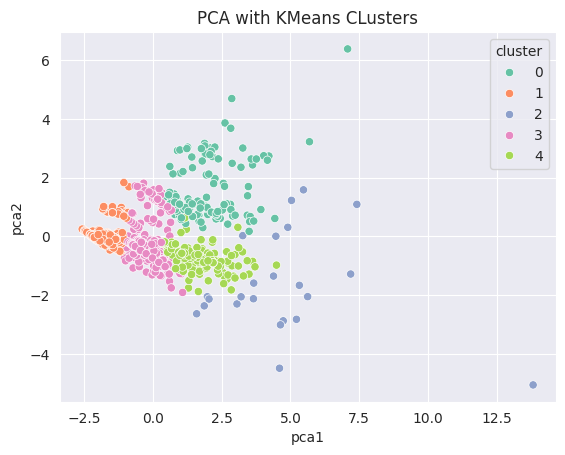

In [114]:
scaler = StandardScaler()
X = scaler.fit_transform(df_descriptors)

#Kmeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
df_descriptors['cluster'] = kmeans.labels_

#PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)
df_descriptors['pca1'] = pca_results[:, 0]
df_descriptors['pca2'] = pca_results[:, 1]

sns.scatterplot(data=df_descriptors, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title('PCA with KMeans CLusters')
plt.show()

### next lets explore UMAP. UMAP is a dimensionality reduction technique that is used for visualization of high-dimensional data
### take the list of dictionaries we created earlier, and create another dataframe from it.
### use this new dataframe to create a UMAP plot with 2 dimensions
### set the umap parameters to n_neighbors = 15, min_dist = 0.1, n_components = 2
### when making the umap plot, set a color bar as the Tg values from the original dataframe


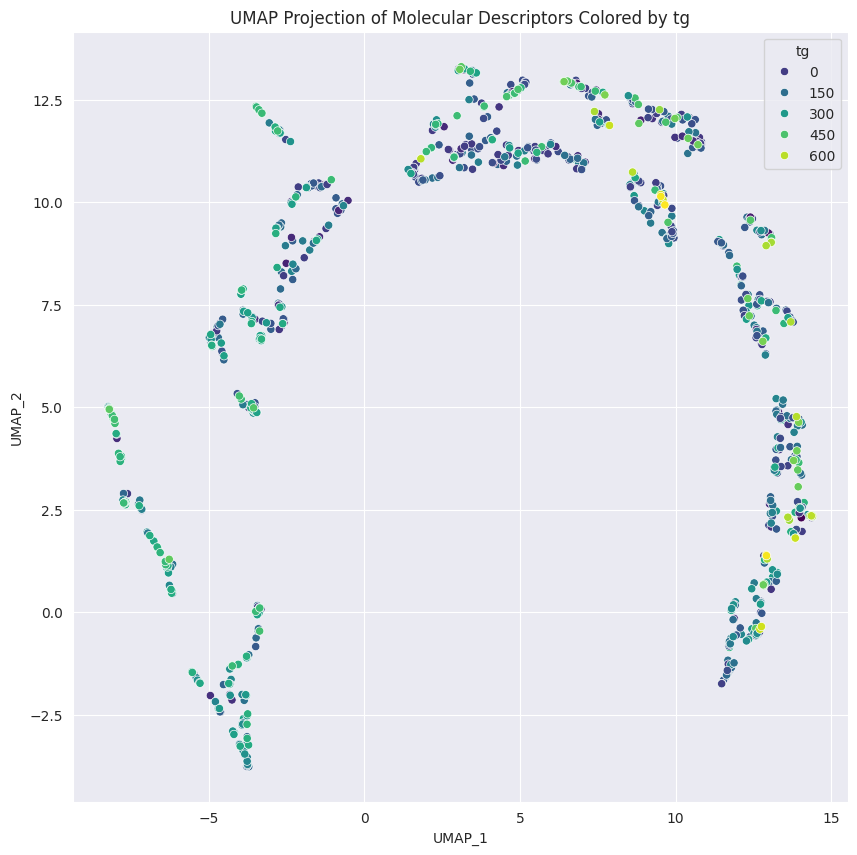

In [116]:
umap_model = umap.UMAP(n_neighbors = 15, min_dist = 0.1, n_components = 2)
umap_result = umap_model.fit_transform(df_descriptors)
umap_df = pd.DataFrame(umap_result,columns=['UMAP_1', 'UMAP_2'])
umap_df['tg'] = df['tg'].values

plt.figure(figsize=(10,10))
sns.scatterplot(
    x = 'UMAP_1',
    y = 'UMAP_2',
    hue = 'tg',
    data=umap_df,
    palette='viridis',
)
plt.title('UMAP Projection of Molecular Descriptors Colored by tg')
plt.show()

### next, create a train test split of the data, using the featurized dataset and the Tg values
### set the test_size =0.3 and a random_state = 42
### traina linear model (ridge regression) and a non-linear model (random forest) on the training data
### test the mdoels on the test set and print the r2 and rmse score for each model
### create 2 parity plots, one for each model
### In either of these parity plots, can you spot a clear outlier in the model?
### if we were to remove this outlier, would our model improve?

In [117]:
# Split and keep original indices
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    df_descriptors, df['tg'], df.index, test_size=0.3, random_state=42)

# Models
ridge = Ridge().fit(X_train, y_train)
rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)

In [118]:
# Predict
y_pred_ridge = ridge.predict(X_test)
y_pred_rf = rf.predict(X_test)

In [119]:
def evaluate_model(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    print(f'{name} R²: {r2:.4f} RMSE: {rmse:.4f}')
    return r2, rmse

In [120]:
print("=== Model Performance ===")
r2_ridge, rmse_ridge = evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
r2_rf, rmse_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")

=== Model Performance ===
Ridge Regression R²: 0.2101 RMSE: 22692.2460
Random Forest R²: 0.4214 RMSE: 16622.2285


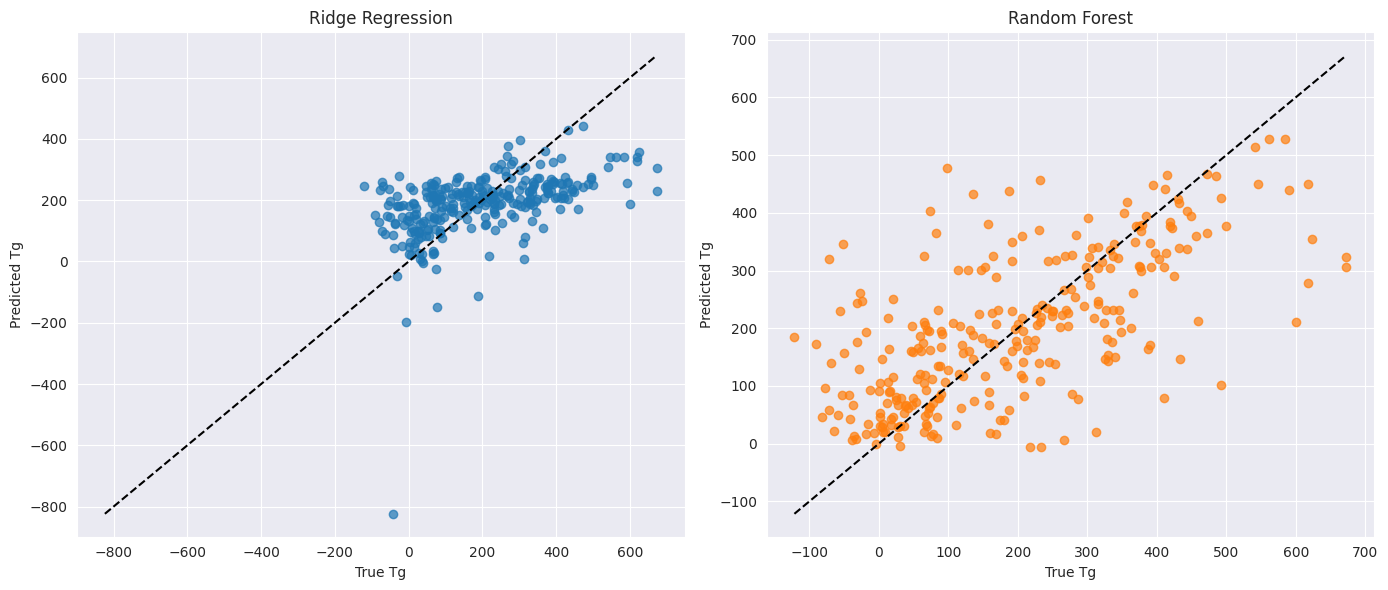

In [121]:
def plot_parity_side_by_side(y_true, y_pred1, y_pred2, title1="Model 1", title2="Model 2"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Plot Ridge Regression
    ax = axes[0]
    ax.scatter(y_true, y_pred1, alpha=0.7, color='tab:blue')
    lims = [min(min(y_true), min(y_pred1)), max(max(y_true), max(y_pred1))]
    ax.plot(lims, lims, '--k')
    ax.set_xlabel('True Tg')
    ax.set_ylabel('Predicted Tg')
    ax.set_title(title1)
    ax.grid(True)

    # Plot Random Forest
    ax = axes[1]
    ax.scatter(y_true, y_pred2, alpha=0.7, color='tab:orange')
    lims = [min(min(y_true), min(y_pred2)), max(max(y_true), max(y_pred2))]
    ax.plot(lims, lims, '--k')
    ax.set_xlabel('True Tg')
    ax.set_ylabel('Predicted Tg')
    ax.set_title(title2)
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_parity_side_by_side(y_test, y_pred_ridge, y_pred_rf,
                         title1="Ridge Regression",
                         title2="Random Forest")

## Szukamy odstajacej wartosci

In [122]:
#dla ridge
results = pd.DataFrame({
    'y_true' : y_test,
    'y_pred': y_pred_ridge
})

results['residual'] = results['y_true'] - results['y_pred']
results.sort_values(by='residual', ascending=False, inplace=True)

worst_idx = results.index[0]
smiles = df.loc[worst_idx, 'SMILES']

print(results)


print("Worst prediction corresponds to SMILES:", smiles)
# Show descriptors
print("Descriptors:")
print(df_descriptors.loc[worst_idx])

         y_true      y_pred    residual
76   -43.360512 -823.549862  780.189350
961  672.000000  230.168859  441.831141
953  600.000000  187.599859  412.400141
962  673.000000  304.403539  368.596461
950  591.000000  256.021925  334.978075
..          ...         ...         ...
275  -27.345003  278.591964 -305.936966
477  -77.911077  232.046302 -309.957378
10   -68.877345  244.917063 -313.794408
66   -71.681071  258.450514 -330.131585
54  -121.521284  245.245462 -366.766746

[290 rows x 3 columns]
Worst prediction corresponds to SMILES: *c1c(cc(c(c1)OCCOCCOCCOCCC(=O)O[Na])C#Cc1c(cc(c(c1)OC(COCCOCCOCCOC)COCCOCCOCCOC)C#C*)OC(COCCOCCOCCOC)COCCOCCOCCOC)OCCOCCOCCOCCC(=O)O[Na]
Descriptors:
MW                 1449.546000
HBD                   0.000000
HBA                  30.000000
TPSA                292.580000
Rotatable_Bonds      74.000000
cluster               2.000000
pca1                 13.832491
pca2                 -5.051566
Name: 76, dtype: float64


## mamy y_true = -43.36051195 i y_pred = -823.549862


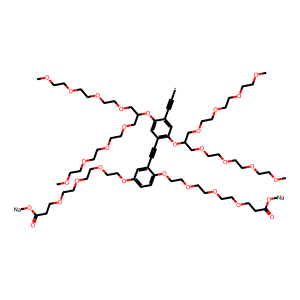

In [123]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = 'c1c(cc(c(c1)OCCOCCOCCOCCC(=O)O[Na])C#Cc1c(cc(c(c1)OC(COCCOCCOCCOC)COCCOCCOCCOC)C#C*)OC(COCCOCCOCCOC)COCCOCCOCCOC)OCCOCCOCCOCCC(=O)O[Na]'
mol = Chem.MolFromSmiles(smiles)
Draw.MolToImage(mol)

### No cos ten random forest daleko w chuj

##The Polish name for Ethyl succinate is:
##Sukcynian etylu

In [124]:
residuals_rf = abs(y_test.values - y_pred_rf)
outlier_pos = residuals_rf.argmax()

print(f"Positional index: {outlier_pos}")
print(f"True Tg: {y_test.iloc[outlier_pos]:.2f}, Predicted Tg: {y_pred_rf[outlier_pos]:.2f}")

Positional index: 75
True Tg: -51.64, Predicted Tg: 345.35


Outlier SMILES in rf: *C(C*)C(=O)OCCOC(C(F)(F)F)(C(F)(F)F)F


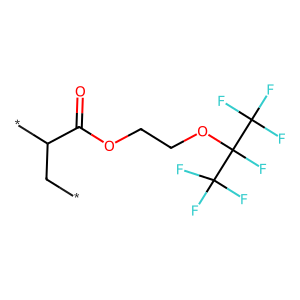

In [125]:
# Get original index and SMILES
rf_outlier_original_index = idx_test[outlier_pos]
outlier_smiles = df.loc[rf_outlier_original_index, 'SMILES']

print("Outlier SMILES in rf:", outlier_smiles)
mol = Chem.MolFromSmiles(outlier_smiles)
Draw.MolToImage(mol)

=== Before Outlier Removal ===
Ridge R²: 0.2101, RMSE: 22692.2460
RF R²: 0.4214, RMSE: 16622.2285

=== After Outlier Removal ===
Ridge (cleaned) R²: 0.2784, RMSE: 20664.5534
RF (cleaned) R²: 0.4363, RMSE: 16134.4215


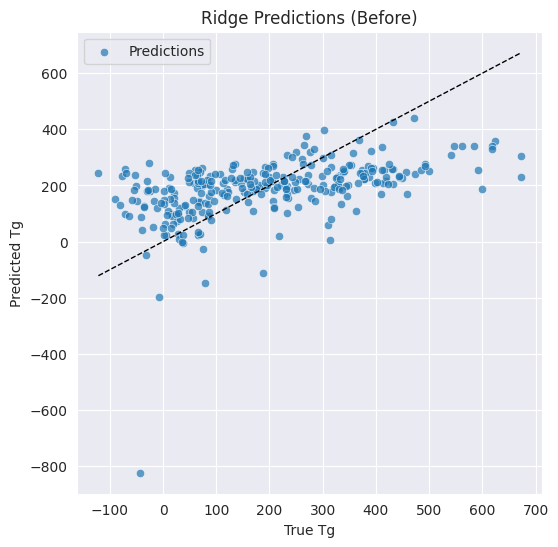

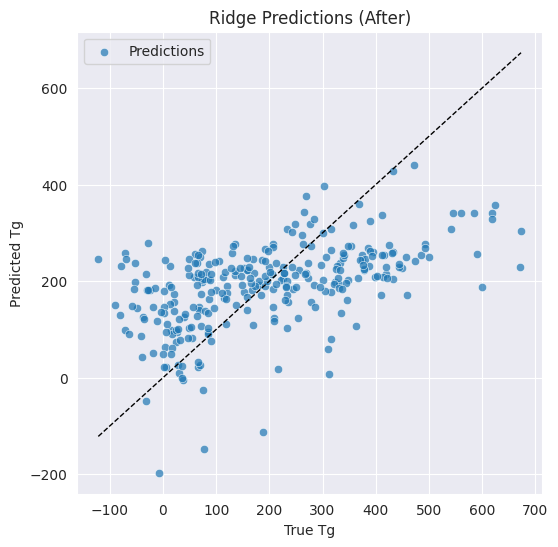

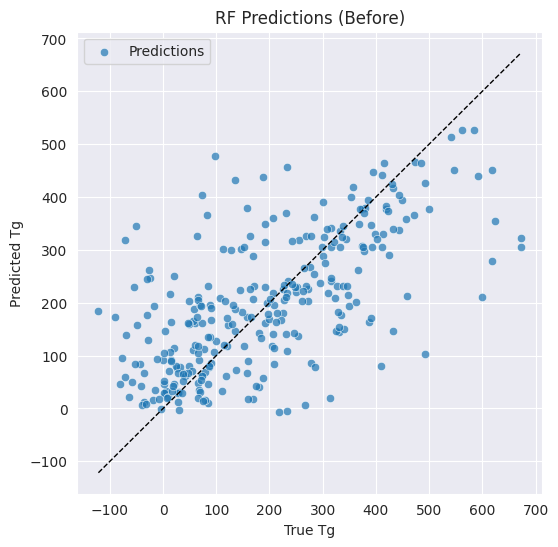

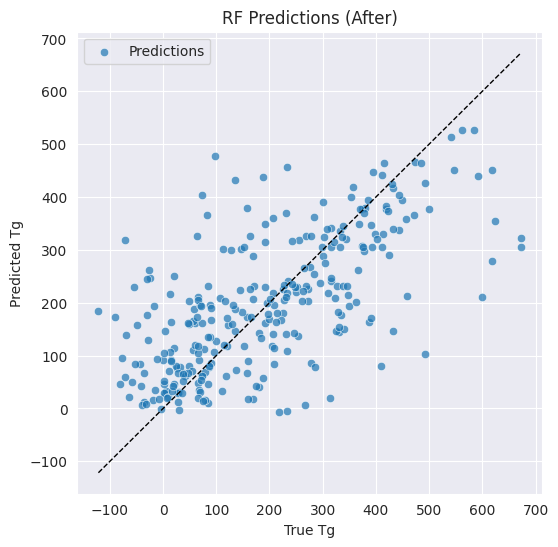

In [126]:
# --- Step 1: Find outlier positions ---
ridge_outlier_pos = np.abs(y_test.values - y_pred_ridge).argmax()
rf_outlier_pos = np.abs(y_test.values - y_pred_rf).argmax()

# --- Step 2: Remove outliers for both models ---
def remove_outlier(pos, X_test, y_test, y_pred):
    mask = np.arange(len(y_test)) != pos
    return X_test.iloc[mask], y_test[mask], y_pred[mask]

# Remove Ridge outlier
X_test_ridge_clean, y_test_ridge_clean, y_pred_ridge_clean = remove_outlier(
    ridge_outlier_pos, X_test, y_test, y_pred_ridge
)

# Remove RF outlier
X_test_rf_clean, y_test_rf_clean, y_pred_rf_clean = remove_outlier(
    rf_outlier_pos, X_test, y_test, y_pred_rf
)

# --- Step 3: Compute metrics before and after cleaning ---
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    print(f"{name} R²: {r2:.4f}, RMSE: {rmse:.4f}")
    return r2, rmse

print("=== Before Outlier Removal ===")
r2_ridge, rmse_ridge = evaluate_model("Ridge", y_test, y_pred_ridge)
r2_rf, rmse_rf = evaluate_model("RF", y_test, y_pred_rf)

print("\n=== After Outlier Removal ===")

# Ridge with cleaned data
r2_ridge_clean, rmse_ridge_clean = evaluate_model("Ridge (cleaned)", y_test_ridge_clean, y_pred_ridge_clean)

# Random Forest with cleaned data
r2_rf_clean, rmse_rf_clean = evaluate_model("RF (cleaned)", y_test_rf_clean, y_pred_rf_clean)

# --- Step 4: Plot Parity Plots Before and After ---

def plot_parity(y_true, y_pred, title, highlight_idx=None):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7, label='Predictions')
    if highlight_idx is not None:
        plt.scatter(y_true[highlight_idx], y_pred[highlight_idx], color='red', s=100, label='Outlier')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=1)
    plt.xlabel('True Tg')
    plt.ylabel('Predicted Tg')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Ridge parity before/after
plot_parity(y_test, y_pred_ridge, "Ridge Predictions (Before)")
plot_parity(y_test_ridge_clean, y_pred_ridge_clean, "Ridge Predictions (After)")

# RF parity before/after
plot_parity(y_test, y_pred_rf, "RF Predictions (Before)")
plot_parity(y_test_rf_clean, y_pred_rf_clean, "RF Predictions (After)")



## troche lepsze R2 i nieznacznie spadlo RSME, wiec usuniecie nie robi za wiele



### next, lets see if using gridsearchcv can improve the performance of the models.
### repeat the above excerise, but this time use gridsearchcv to find the best hyperparameters for the models
### for the ridge model set the param_grid for alpha to alpha = [0.01, 0.1, 1.0, 10, 100], set cv =5, scoring= r^2 and n_jobs = -1.
### For the random forest model use this param_grid to search through param_grid_rf = {
###    'n_estimators': [50, 100, 200],
###    'max_depth': [None, 5, 10],}
### print the best score and the best parameters for each model
### create a model from the best parameters and test the model on the test set
###


In [135]:
# Ridge
param_grid_ridge = {'alpha': [0.01, 0.1, 1.0, 10, 100]}
grid_ridge = GridSearchCV(Ridge(), param_grid_ridge, scoring='r2', cv=5, n_jobs=-1, verbose=0)
grid_ridge.fit(X_train, y_train)
warnings.filterwarnings("ignore")
# Print best parameters
print("Best Ridge Params:", grid_ridge.best_params_)
# Test best models
best_ridge = grid_ridge.best_estimator_

print("\n=== Best Model Performance ===")
y_pred_best_ridge = best_ridge.predict(X_test)
evaluate_model("Best Ridge",y_test, y_pred_best_ridge)



Best Ridge Params: {'alpha': 100}

=== Best Model Performance ===
Best Ridge R²: 0.2128, RMSE: 22614.5288


/home/ssavvo/projekty/ML_KROS/myenv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ssavvo/projekty/ML_KROS/myenv/lib/python3.12/site-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/ssavvo/projekty/ML_KROS/myenv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. 

(0.2128398995350681, 22614.528791553003)

In [131]:
warnings.filterwarnings("ignore")

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
}

rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
evaluate_model("Best RF", y_test, y_pred_best_rf)

/home/ssavvo/projekty/ML_KROS/myenv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ssavvo/projekty/ML_KROS/myenv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ssavvo/projekty/ML_KROS/myenv/lib/python3.12/site-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should b

In [132]:
print("Best RF Params:", grid_rf.best_params_)
print("Best RF Score (R²):", grid_rf.best_score_)
print("Best RF Parameters:", grid_rf.best_params_)

Best RF Params: {'max_depth': 10, 'n_estimators': 200}
Best RF Score (R²): 0.3989950176853131
Best RF Parameters: {'max_depth': 10, 'n_estimators': 200}


In [133]:
print("=== Model Performance ===")
r2_ridge, rmse_ridge = evaluate_model("Ridge Regression",y_test, y_pred_ridge)
r2_rf, rmse_rf = evaluate_model("Random Forest",y_test, y_pred_rf)



=== Model Performance ===
Ridge Regression R²: 0.2101, RMSE: 22692.2460
Random Forest R²: 0.4214, RMSE: 16622.2285


In [136]:
print("\n=== Model Comparison ===")
print(f"{'Model':<10} | {'Train R²':<8} | {'Test R²':<8} | {'Test RMSE'}")

def print_model(name, grid, y_true, y_pred):
    train_score = grid.best_score_
    test_score = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    print(f"{name:<10} | {train_score:.4f}   | {test_score:.4f}   | {rmse:.4f}")

print_model("Ridge", grid_ridge, y_test, y_pred_ridge)
print_model("RF", grid_rf, y_test, y_pred_rf)


=== Model Comparison ===
Model      | Train R² | Test R²  | Test RMSE
Ridge      | 0.2759   | 0.2101   | 22692.2460
RF         | 0.3990   | 0.4214   | 16622.2285


In [137]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("Dummy R²:", r2_score(y_test, y_pred_dummy))
print("Dummy RMSE:", mean_squared_error(y_test, y_pred_dummy))

Dummy R²: -0.0018163890709028685
Dummy RMSE: 28781.445554865128


## Realization

After so many steps and changes in model I realised that RMSE is waaay off
With Dummy model that is a baseline R2 is just bad because it's below 0, but RMSE is 28781.445554865128

I checked the range of values Tg and it looks like this:

In [48]:
print(min(df.tg))
print(max(df.tg))

-148.0297376
685.0


The problem is probably with the fact that I scaled Y when I shouldn't

### next, lets generate features from the get_morgan_fingerprint function
### create one list called morgan_fingerprints of the morgan fingerprints for each smiles string in the dataset
### next, create a new dataframe from the morgan_fingerprints list
### next, split the data set into a test and train set using the Tg values as your target variable,
### set the test_size = 0.3 and random_state = 42
### standardize the data using the StandardScaler, and train a linear ridge(alpha=0.1) model and a non-linear random forest(n_estimators=100,random_state=42) model
### test the models on the test set and print the r2 and rmse score for each model
### plot a parity plot for each model 

### next lets use the get_topological_fingerprint function to generate 2D structural features of our smiles strings
### create a list called topological_fps of the topological fingerprints for each smiles string in the dataset
### and convert this to a dataframe. Create a train test split of the data using the Tg values as the target variable
### set the test_size = 0.3 and random_state = 42. 
### for this excercise we are going to train a Support vector regression and a random forest model.
### We will also want to create a 3rd model called ensemble made up of both of the models.
### using the VotingRegressor from sklearn.ensemble, create a model that combines the SVR and random forest models.
### test each model, print the r2 and rmse score for each all 3 models as well as a parity plot for each model.
### Do we see any improvement in the performance of the models when we combine into an ensemble of models?

### for the final excercise, we are going to identify the most similar molecules in our dataset relative to the first molecule in the dataset.
### so we want to compare how similar the first molecule is to the rest of the molecules in the dataset
### generate morgan fingerprints for the first molecule in the dataset and compare it to the rest of the molecules in the dataset
### you'll first generate morgan fingerprints(radius=2, nBits=1024) for the first molecule in the dataset
### and then for the rest of the molecules in the dataset. Calulate the Tanimoto similarity between the first molecule and the rest of the molecules in the dataset, print the top 10 most similar molecules to the first molecule in the dataset
### it should look something like this:

### Most similar molecules:
###                             SMILES                                                     Similarity
### 0    *C1COC2C1OCC2Oc1ccc(cc1)CNC(=O)CCCCCCC(=O)NCc1...                                  1.000000
### 222                 *N=Occ1                                                             0.444444
### 333  *Oc1cCC(=O)NCCCc1cccOC...                                                          0.428571
### 444  *C1C2OC(=O)CCC(=O)O                                                                0.428571
### 20   *NC....                                                                            0.425926
### 12   *OC(=O)CNC...                                                                      0.353846

### use MolsToGridImage to display the molecule and the 4 most similar molecules to the first molecule in the dataset.